# Association Rules

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. This way retailers can use the data to identify relationships between the items that people buy.

Association Rules are widely used to analyze retail basket or transaction data and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

In [1]:
# import the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules as arule

### Read data from Groceries_dataset.csv

The data set contains 38765 transactions where each transaction has a corresponding customer (identified through his Member_number), a timestamp (Date) and the name of the single item that the customer bought (itemDescription).

In [2]:
# Read data from file "Groceries_dataset.csv"
groceries_data = pd.read_csv("Groceries_dataset.csv")

# Preview first 5 lines of the loaded data
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
# Extract total number of items in the dataset.

groceries_data['itemDescription'].nunique()

167

What is the number of possible itemsets?

Answer:
    $2^{167} - 1$

### Transform dataset

In [4]:
# Obtain the number of unique customers and interpret its value w.r.t. the number of rows in the dataset.

no_customers = groceries_data['Member_number'].nunique()

print(len(groceries_data))
print(no_customers)

38765
3898


Note: Since there are many more rows in the dataset than customers, some customers have more than one corresponding transaction.

Create a new dataframe with two columns: "Member_number" and "itemDescription". Each member number should appear only once and the "itemDescription" should contain all items (without duplicates) purchased by the customer with that member number.

In [5]:
customer_items_df = pd.DataFrame(groceries_data.groupby('Member_number')['itemDescription'].apply(lambda s: s.unique()))
customer_items_df.head()

,itemDescription
Member_number,
1000,"[soda, canned beer, sausage, whole milk, pickl..."
1001,"[frankfurter, beef, sausage, whole milk, soda,..."
1002,"[tropical fruit, butter milk, butter, frozen v..."
1003,"[sausage, root vegetables, rolls/buns, deterge..."
1004,"[other vegetables, pip fruit, root vegetables,..."


### Frequent Itemsets 

The association rules we are interested in are rules of the form $A \Rightarrow B$ such that $A \cup B$ is frequent in the dataset, that is, $support(A \cup B) \geq min\_sup$ where $min\_sup \in [0,1]$ is the threshold.

TransactionEncoder receives a list of sets of items and transforms it into a matrix such that the value in the i-th row and the j-th column is $True$ if the i-th itemset contains product j, and $False$ otherwise.

In [6]:
# obtain boolean matrix using TransactionEncoder() on the column of itemsets
itemsets_data = customer_items_df['itemDescription'].tolist()
te = TransactionEncoder()
boolean_matrix = te.fit(itemsets_data).transform(itemsets_data)
# create new dataframe such that the names of the products appear as column names
boolean_df = pd.DataFrame(boolean_matrix, columns = te.columns_)

boolean_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Obtain the set of frequent itemsets using the apriori method provided by mlxtend with min_support = 0.05.

In [7]:
frequent_itemsets = apriori(boolean_df, min_support=0.05, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.078502,(UHT-milk)
1,0.119548,(beef)
2,0.079785,(berries)
3,0.062083,(beverages)
4,0.158799,(bottled beer)
...,...,...
160,0.050539,"(other vegetables, tropical fruit, whole milk)"
161,0.071832,"(other vegetables, whole milk, yogurt)"
162,0.065162,"(rolls/buns, soda, whole milk)"
163,0.065931,"(rolls/buns, whole milk, yogurt)"


### The Apriori Principle

The Apriori algorithm constructs frequent itemsets by exploiting the property that "Going from a set to any of its subsets, the frequency (here: support in the data) can not decrease, only stay equal or increase. Equivalently, going from a set to some superset containing it, the frequency (here: support in the data) can not increase, only stay equal or decrease." Thus, any frequent itemset of size $k$ has only frequent subsets. This is exploited when constructing the candidate sets of size $k$ from the frequent sets of size $k-1$.

Implement a function which, given the frequent itemsets (e.g.obtained by apriori) and a number k, returns a subset of frequent itemsets where all itemsets have size k. 

In [8]:
def get_freq_itemsets_by_size(frequent_itemsets, k):
    
    data = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == k)]
    
    return data

Suppose that for each candidate itemset, a full scan of the database is performed to estimate the support of that itemset. In the following, we will see how the apriori property in the pruning step of the Apriori algorithm reduces the number of candidate itemsets. For this, we implement (a straight-forward version of) the joining and pruning step of the algorithm which computes set C3 from L2.
- The join step: On input L2 (set of frequent itemsets of size $2$), merge those itemsets accordingly (as explained in the lecture) to obtain itemsets of size $3$. Return those itemsets.
- The prune step: Given set of candidate itemsets of size $3$ and set of frequent itemsets of size $2$, remove the candidate sets that contain an infrequent subset of size $2$ and return the rest.

In [9]:
def apriori_gen(L2):
    
    C3 = []
    
    for itemset1 in L2:
        for itemset2 in L2:
            if itemset1 != itemset2:
                # for any two pairs of frequent itemsets of size 2, compute their intersection
                intersec = set(itemset1).intersection(itemset2)
                if len(intersec) == 1:
                # if intersection has size 2-1=1, merge them and form new candidate set of size 3
                    C3.append(set(itemset1).union(set(itemset2)))
    
    return C3

In [10]:
def apriori_prune(C3, L2):
    
    C_pruned = []
    
    for candidate_set in C3:
        for (i,item) in enumerate(candidate_set):
            # since we want to look at different subsets of same itemset many times, 
            # each time we get the subsets from a copy of it, so that we still can assess the original itemset
            candidate_copy = set(candidate_set).copy()
            # remove one of the 3 items, leaving a set of size 2
            candidate_copy.remove(item)
            # check if itemset of size 2 is frequent
            if candidate_copy not in L2:
                break #stop exploring this candidate set, we would jump to the outer for loop 
            if i == len(candidate_set)-1:
                # if we make it thorugh all subsets of size 2, we keep the current candidate set of size 3
                C_pruned.append(candidate_set)
                    
    return C_pruned

To see the effect of the apriori property, we compare the number of candidate itemsets of size 3 obtained without pruning and with pruning for different thresholds for min_support. To achieve this, we call the apriori function on the dataframe boolean_df and set min_support to all values in $[0.02,0.04,0.06,...,0.36,0.38]$. Use the apriori_gen() and apriori_prune() functions you implemented to obtain the candidate sets before and after pruning. You should return a list of triples (min_sup, C3_size, C3_size_pruned) where min_sup is the value of min_support, C3_size is the corresponding number of candidate itemsets of size 3 without pruning, and C3_size_pruned is the corresponding number of candidate itemsets of size 3 after pruning.

In [11]:
def obtain_stats(dataset, min_sup_values):
    
    stats = []
    
    for value in min_sup_values:
        frequent_value = apriori(boolean_df, min_support=value, use_colnames=True)
        frequent_size2 = get_freq_itemsets_by_size(frequent_value, 2)

        if not frequent_size2.empty:
            L2 = frequent_size2['itemsets'].tolist()
            C3_all = apriori_gen(L2)
            C3_pruned = apriori_prune(C3_all, L2)
            stats.append((value, len(C3_all), len(C3_pruned)))
    
    return stats

In [12]:
min_sup_values = np.arange(0.02,0.38,0.02)
stats = obtain_stats(boolean_df, min_sup_values)

Plot the number of candidate sets with and without pruning against the min_sup values. 

In [13]:
min_sup_values, C3_sizes, C3_sizes_pruned = zip(*stats) 
x_axis = min_sup_values

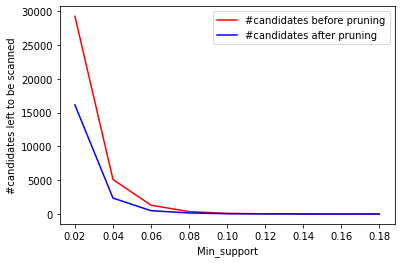

In [14]:
plt.plot(x_axis, C3_sizes, color='red', label='#candidates before pruning')
plt.plot(x_axis, C3_sizes_pruned, color='blue', label='#candidates after pruning')
plt.legend()
plt.xlabel('Min_support')
plt.ylabel('#candidates left to be scanned')
plt.show()

### Generating rules

Using only the frequent itemsets with min_sup=0.05 (the frequent_itemsets we obtained before), generate different association rules using min_conf=0.2, min_conf=0.5 and min_conf=0.8 as a metric. Comment on the number of association rules that are found.

In [15]:
assoc_rules_conf_02 = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.2)
assoc_rules_conf_02

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(beef),(other vegetables),0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966
1,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919
2,(bottled beer),(other vegetables),0.158799,0.376603,0.068497,0.431341,1.145345,0.008692,1.096257
3,(bottled beer),(rolls/buns),0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240
4,(bottled beer),(soda),0.158799,0.313494,0.055156,0.347334,1.107946,0.005374,1.051849
...,...,...,...,...,...,...,...,...,...
178,"(whole milk, yogurt)",(rolls/buns),0.150590,0.349666,0.065931,0.437819,1.252106,0.013275,1.156805
179,(yogurt),"(rolls/buns, whole milk)",0.282966,0.178553,0.065931,0.233001,1.304939,0.015407,1.070988
180,"(soda, whole milk)",(yogurt),0.151103,0.282966,0.054387,0.359932,1.271999,0.011630,1.120247
181,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537


In [16]:
assoc_rules_conf_05 = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.5)
assoc_rules_conf_05

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919
1,(bottled beer),(whole milk),0.158799,0.458184,0.085428,0.537964,1.174124,0.012669,1.172672
2,(bottled water),(whole milk),0.213699,0.458184,0.112365,0.525810,1.147597,0.014452,1.142615
3,(brown bread),(whole milk),0.135967,0.458184,0.069779,0.513208,1.120091,0.007481,1.113034
4,(butter),(whole milk),0.126475,0.458184,0.066188,0.523327,1.142176,0.008239,1.136661
5,(canned beer),(whole milk),0.165213,0.458184,0.087224,0.527950,1.152268,0.011526,1.147795
6,(curd),(whole milk),0.120831,0.458184,0.063622,0.526539,1.149188,0.008259,1.144374
7,(domestic eggs),(whole milk),0.133145,0.458184,0.070292,0.527938,1.152242,0.009287,1.147766
8,(frozen vegetables),(whole milk),0.102617,0.458184,0.055156,0.537500,1.173110,0.008139,1.171495
9,(margarine),(whole milk),0.116983,0.458184,0.059518,0.508772,1.110410,0.005918,1.102983


In [17]:
assoc_rules_conf_08 = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.8)
assoc_rules_conf_08

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


The higher the confidence threshold, the lower the number of association rules that are classified as "strong". For min_conf set to 0.8, no association rule is generated.

Using only the frequent itemsets with min_sup=0.05 (the frequent_itemsets we obtained before), generate different association rules using min_lift=0.5, min_lift=1 and min_lift=1.4 as a metric. Comment on the number of association rules that are found.

In [18]:
assoc_rules_lift_05 = arule(frequent_itemsets, metric = 'lift', min_threshold = 0.5)
assoc_rules_lift_05

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(beef),0.376603,0.119548,0.050795,0.134877,1.128223,0.005773,1.017719
1,(beef),(other vegetables),0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966
2,(whole milk),(beef),0.458184,0.119548,0.064135,0.139978,1.170886,0.009360,1.023754
3,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919
4,(other vegetables),(bottled beer),0.376603,0.158799,0.068497,0.181880,1.145345,0.008692,1.028212
...,...,...,...,...,...,...,...,...,...
255,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537
256,"(whole milk, yogurt)",(soda),0.150590,0.313494,0.054387,0.361158,1.152042,0.007178,1.074611
257,(soda),"(whole milk, yogurt)",0.313494,0.150590,0.054387,0.173486,1.152042,0.007178,1.027702
258,(whole milk),"(soda, yogurt)",0.458184,0.097486,0.054387,0.118701,1.217622,0.009720,1.024073


In [19]:
assoc_rules_lift_1 = arule(frequent_itemsets, metric = 'lift', min_threshold = 1)
assoc_rules_lift_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(beef),0.376603,0.119548,0.050795,0.134877,1.128223,0.005773,1.017719
1,(beef),(other vegetables),0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966
2,(whole milk),(beef),0.458184,0.119548,0.064135,0.139978,1.170886,0.009360,1.023754
3,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919
4,(other vegetables),(bottled beer),0.376603,0.158799,0.068497,0.181880,1.145345,0.008692,1.028212
...,...,...,...,...,...,...,...,...,...
253,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537
254,"(whole milk, yogurt)",(soda),0.150590,0.313494,0.054387,0.361158,1.152042,0.007178,1.074611
255,(soda),"(whole milk, yogurt)",0.313494,0.150590,0.054387,0.173486,1.152042,0.007178,1.027702
256,(whole milk),"(soda, yogurt)",0.458184,0.097486,0.054387,0.118701,1.217622,0.009720,1.024073


In [20]:
assoc_rules_lift_13 = arule(frequent_itemsets, metric = 'lift', min_threshold = 1.3)
assoc_rules_lift_13

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(other vegetables, whole milk)",(bottled water),0.191380,0.213699,0.056183,0.293566,1.373732,0.015285,1.113056
1,"(other vegetables, bottled water)",(whole milk),0.093894,0.458184,0.056183,0.598361,1.305941,0.013162,1.349012
2,"(whole milk, bottled water)",(other vegetables),0.112365,0.376603,0.056183,0.500000,1.327657,0.013865,1.246793
3,(other vegetables),"(whole milk, bottled water)",0.376603,0.112365,0.056183,0.149183,1.327657,0.013865,1.043273
4,(whole milk),"(other vegetables, bottled water)",0.458184,0.093894,0.056183,0.122620,1.305941,0.013162,1.032741
5,(bottled water),"(other vegetables, whole milk)",0.213699,0.191380,0.056183,0.262905,1.373732,0.015285,1.097036
6,"(other vegetables, whole milk)",(yogurt),0.191380,0.282966,0.071832,0.375335,1.326434,0.017678,1.147870
7,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,0.016704,1.344507
8,(whole milk),"(other vegetables, yogurt)",0.458184,0.120318,0.071832,0.156775,1.303003,0.016704,1.043235
9,(yogurt),"(other vegetables, whole milk)",0.282966,0.191380,0.071832,0.253853,1.326434,0.017678,1.083727


#### Demonstrating selective metrics of association rules in one table
In this section, you will learn how to show selective metrics of association rules in one table.

In [21]:
# Mine association rules from the discovered frequent itemsets with min_sup = 0.05.

# Store the discovered association rules with min_conf = 0.5 in variable 'assoc_rules'.

assoc_rules =arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.5)

# Keep only the rules with lift larger than 1 and support larger than 0.1, store the discovered rules in variable 'filtered_rules'.

filtered_rules = assoc_rules.loc[(assoc_rules['lift'] > 1) & (assoc_rules['support'] > 0.1)]     

# Show the columns 'antecedents', 'consequents', 'support', 'confidence' and 'lift' of variable 'filtered_rules' 

filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
2,(bottled water),(whole milk),0.112365,0.525810,1.147597
11,(other vegetables),(whole milk),0.191380,0.508174,1.109106
15,(rolls/buns),(whole milk),0.178553,0.510638,1.114484
16,(sausage),(whole milk),0.106978,0.519303,1.133394
19,(yogurt),(whole milk),0.150590,0.532185,1.161510


Comment on the remaining association rules.

All rules have $\{\text{whole milk}\}$ in the consequent. 

Let's see the number of itemsets containing milk.

In [22]:
itemsets_with_milk = 0
for itemset in itemsets_data:
    if 'whole milk' in itemset:
        itemsets_with_milk += 1

print(itemsets_with_milk)
print(itemsets_with_milk/len(itemsets_data))

1786
0.4581836839404823


We can see that almost every second customer buys whole milk. This explains why all strongest association rules contain whole milk on the right-hand side.

## Sequence Mining

In [23]:
# format date column to be able to sort it later
groceries_data['Date'] = pd.to_datetime(groceries_data['Date'], format='%d-%m-%Y')

Create a new variable itemset_sequences which contains lists of items where each list corresponds the sequence of the purchased items. The order of items in each list is determined by the date (ascending order, break ties randomly).

In [24]:
groceries_data = groceries_data.sort_values(['Member_number', 'Date'])

In [25]:
itemset_sequences = groceries_data.groupby('Member_number')['itemDescription'].apply(list).tolist()

Implement a function that given two sequences of strings determines whether the first is a subsequence (that is, contained) of the second one.

In [26]:
def contained(is_seq1, is_seq2):
    size1 = len(is_seq1)
    size2 = len(is_seq2)
    
    if size1 > size2:
        return False

    last_1 = 0
    last_2 = 0
    
    while last_1 < size1 and last_2 < size2:
        item1 = is_seq1[last_1]
        item2 = is_seq2[last_2]
        if item1 == item2:
            last_1 += 1
        last_2 += 1
                          
    if last_1 == size1:
        return True
    else:
        return False             

Use the set of frequent itemsets with min_sup=0.05 to filter only the itemsets with two items.

In [27]:
frequent_size2 = get_freq_itemsets_by_size(frequent_itemsets, 2)
frequent_size2

,support,itemsets
57,0.050795,"(other vegetables, beef)"
58,0.064135,"(whole milk, beef)"
59,0.068497,"(other vegetables, bottled beer)"
60,0.063109,"(rolls/buns, bottled beer)"
61,0.055156,"(soda, bottled beer)"
...,...,...
149,0.097486,"(soda, yogurt)"
150,0.116470,"(tropical fruit, whole milk)"
151,0.075680,"(tropical fruit, yogurt)"
152,0.079785,"(whipped/sour cream, whole milk)"


Choose one of those itemsets and compute the number of sequences that contain the itemset in each possible order.

In [28]:
# for set {x,y}, count how many sequences contain sequence [x,y] and how many contain [y,x]

chicken_milk = ['chicken', 'whole milk']
milk_chicken = ['whole milk', 'chicken']
no_chicken_milk = 0
no_milk_chicken = 0

for sequence in itemset_sequences:
    
    if contained(chicken_milk, sequence):
        no_chicken_milk += 1
    if contained(milk_chicken, sequence):
        no_milk_chicken += 1
        
print(no_chicken_milk)
print(no_milk_chicken)

113
115


Since both orderings appear roughly the same amount of times in the sequences of purchased items, we might conclude that either we have many customers buying the products each with a particular order, or that such basic products are purchased a numerous amount of times by each customer.

## Simpson's Paradox

We will analyze a dataset on Delta Variant Covid-19 cases in the UK. This dataset gives a great example of Simpson's Paradox. When aggregating results without regard to age group, the death rate for vaccinated individuals is higher – but they have a much higher risk population. Once we look at populations with more comparable risks (breakout age groups), we see that the vaccinated group tends to be lower risk in each risk-bucketed group and that many of the higher risk patients had gotten vaccinated.

### Read data from covid_dataset.csv

The dataset contains 286166 rows with three variables. Each row corresponds to an individual, `age_group` indicates the age of the person (can be "under 50" or "50 +"), `vaccine_status` indicates whether the person was vaccinated against Covid ("vaccinated" if at least one vaccine shot was received, otherwise "unvaccinated") and `outcome` reveals whether the person died from the Delta variant (values can be "death" or "survived"). 

In [29]:
# Read data from file "Groceries_dataset.csv"
covid_data = pd.read_csv("covid_dataset.csv")

# Preview first 5 lines of the loaded data
covid_data.head(5)

,age_group,vaccine_status,outcome
0,under 50,vaccinated,death
1,under 50,vaccinated,death
2,under 50,vaccinated,death
3,under 50,vaccinated,death
4,under 50,vaccinated,death


For each vaccination group, compute the death/survivor rate and compare them.

In [30]:
table_aggregated = pd.pivot_table(data=covid_data,index=['vaccine_status'], columns=['outcome'], aggfunc='count')

In [31]:
table_aggregated

age_group         
outcome            death survived
vaccine_status                   
unvaccinated         253   150799
vaccinated           481   116633

In [33]:
print("The death rate for vaccinated individuals is " + str(481/(481+116633)*100) + "%.")
print("The death rate for unvaccinated individuals is " + str(253/(253+150799)*100) + "%.")

The death rate for vaccinated individuals is 0.41071093122940044%.
The death rate for unvaccinated individuals is 0.16749198951354502%.


It seems like in the unvaccinated population, the risk of not surviving the Delta variant was lower. 

For each vaccination and age group combination, compute the death/survivor rate per combination. What do you notice?

In [34]:
table_by_age = pd.pivot_table(data=covid_data,index=['vaccine_status', 'age_group'], columns=['outcome'], aggfunc={'outcome': 'count'})

In [35]:
table_by_age

outcome         
outcome                    death survived
vaccine_status age_group                 
unvaccinated   50 +          205     3235
               under 50       48   147564
vaccinated     50 +          460    26847
               under 50       21    89786

In [36]:
print("The death rate for vaccinated individuals under 50 is " + str(21/(21+89786)*100) + "%.")
print("The death rate for unvaccinated individuals under 50 is " + str(48/(48+147564)*100) + "%.")

The death rate for vaccinated individuals under 50 is 0.023383477902613383%.
The death rate for unvaccinated individuals under 50 is 0.032517681489309815%.


In [37]:
print("The death rate for vaccinated individuals over 50 is " + str(460/(460+26847)*100) + "%.")
print("The death rate for unvaccinated individuals over 50 is " + str(205/(205+3235)*100) + "%.")

The death rate for vaccinated individuals over 50 is 1.68454974914857%.
The death rate for unvaccinated individuals over 50 is 5.959302325581396%.


It seems that in each of the age groups, the chance of surviving as a vaccinated individual was higher than when unvaccinated.

But where does this paradox comes from? 1) Persons under 50 have lower risk and 2) The unvaccinated population has far more persons under 50 (from the total amount of people in the sample) than the vaccinated population (probably because the older generation was first to get vaccinated). Thus, when aggregating the data, the unvaccinated people seem to have better chance of surviving. The underlying variable explaining this is the age. We need to keep the age group fixed and then compare the two populations (vaccinated/unvaccinated) w.r.t. their chance of survival. Only then we can argue about the effect of the vaccination on the chance of survival.